# Perform time series forecasting using XGBoost

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error

from skopt import BayesSearchCV

from joblib import dump
from joblib import load

In [24]:
df = pd.read_csv("./data/processed/mastercard_processed.csv", parse_dates = True, index_col = ["Date"])
df.head()

,Open,Volume,Close,month,day,quarter,lag_1,lag_2,MA,M_STD
Date,,,,,,,,,,
2006-06-29,4.367592,14470000.0,4.46527,6,3,2,4.368524,4.401083,4.325699,0.125787
2006-06-30,4.432710,25964000.0,4.46527,6,4,2,4.465270,4.368524,4.338103,0.120293
2006-07-01,4.432710,25964000.0,4.46527,7,5,3,4.465270,4.465270,4.347592,0.118657
2006-07-02,4.432710,25964000.0,4.46527,7,6,3,4.465270,4.465270,4.349111,0.119898
2006-07-03,4.455966,7029000.0,4.40015,7,0,3,4.465270,4.465270,4.352243,0.121711


In [25]:
# scale data
scaler = StandardScaler()
cols_to_standardize = ['Open', "Volume", "lag_1", "lag_2", "MA", "M_STD"]
df[cols_to_standardize] = scaler.fit_transform(df[cols_to_standardize])

## Modelling

In [26]:
# split data into last 20 days to predict as test data
df_train = df.iloc[:-100]
df_val = df.iloc[-100:-50]
df_test = df.iloc[-50:]

X_train = df_train[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]]
y_train = df_train[["Close"]]

X_val = df_val[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]]
y_val = df_val[["Close"]]

X_test = df_test[["Open", "Volume", "month", "day", "quarter", "lag_1", "lag_2", "MA", "M_STD"]]
y_test = df_test[["Close"]]

In [27]:
model = XGBRegressor(objective = "reg:squarederror", random_state = 42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
# check RMSE for training data
y_pred = model.predict(X_train)
mse = mean_squared_error(y_train, y_pred)

print(f"Root mean squared error is: {np.sqrt(mse) : .2f}")

Root mean squared error is:  0.88


In [29]:
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

print(f"Root mean squared error is: {np.sqrt(mse) : .2f}")

Root mean squared error is:  21.57


We can see that RMSE for train data is much smaller than that of the validation data

In [30]:
y_pred

array([484.28497, 482.62   , 480.70892, 478.25226, 478.76468, 481.44086,
       484.50687, 484.8847 , 479.91528, 479.65924, 479.71585, 481.84854,
       482.40457, 481.08905, 476.8106 , 477.32684, 476.09372, 476.21393,
       481.10574, 476.90683, 478.6883 , 476.23865, 478.0245 , 478.16898,
       478.64185, 479.30704, 476.5242 , 483.50644, 478.3191 , 482.52374,
       482.26138, 481.92755, 480.73303, 476.33066, 474.66354, 470.87042,
       475.16568, 475.87735, 475.68207, 472.0702 , 471.00543, 476.26718,
       475.7775 , 479.46277, 478.30573, 478.51028, 481.05072, 483.87955,
       483.13077, 482.1135 ], dtype=float32)

Plot the predicted and actual data

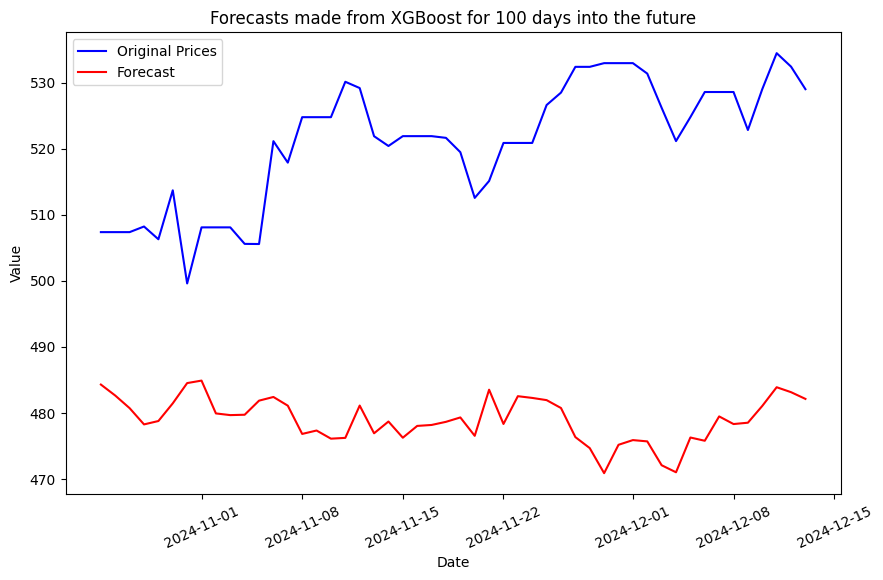

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label = "Original Prices", color = "blue")
plt.plot(X_test.index, y_pred, label = "Forecast", color = "red")

# Add labels and title
plt.title("Forecasts made from XGBoost for 100 days into the future")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

## Tune the XGB model

In [32]:
# define function to tune parameters

def tune_xgb(new_param_name: str, new_param_space: np.ndarray, current_best_params: dict) -> dict:
    '''
    Tunes a certain parameter of XGBRegressor.

    Args:
        new_param_name: name of parameter to tune in XGBRegressor docs
        new_param_space: numpy ndarray of values the parameter can take
        current_best_params: best parameters that have been tuned so far
    
    Returns:
        current_best_params: updated dictionary of the best parameters so far
    '''
    best_rmse = float('inf')
    best_param = 0

    for param in new_param_space:
        current_best_params[new_param_name] = param
        model = XGBRegressor(**current_best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        if rmse < best_rmse:
            best_rmse = rmse
            best_param = param
        
    print(f"Best RMSE is: {best_rmse}, with {new_param_name}: {best_param}")

    current_best_params[new_param_name] = best_param

    return current_best_params

### Tune eta (learning rate)

In [33]:
learning_rate = np.arange(0.0, 1.1, 0.1)
current_best_params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "eval_metric": "rmse"
}

tune_xgb("eta", learning_rate, current_best_params)

Best RMSE is: 35.30472107783032, with eta: 0.9


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9)}

### Tune min_split_loss

In [34]:
min_split_losses = np.arange(0, 100, 0.5)
tune_xgb("min_split_loss", min_split_losses, current_best_params)

Best RMSE is: 34.97400591895396, with min_split_loss: 34.5


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5)}

### Tune max_depth

In [35]:
max_depths = np.arange(1, 50, 1)
tune_xgb("max_depth", max_depths, current_best_params)

Best RMSE is: 34.97400591895396, with max_depth: 6


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5),
 'max_depth': np.int64(6)}

### Tune reg_lambda

In [36]:
reg_lambdas = np.arange(0, 100, 1)
tune_xgb("reg_lambda", reg_lambdas, current_best_params)

Best RMSE is: 34.97400591895396, with reg_lambda: 1


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5),
 'max_depth': np.int64(6),
 'reg_lambda': np.int64(1)}

### Tune reg_alpha

In [37]:
reg_alphas = np.arange(0, 100, 1)
tune_xgb("reg_alpha", reg_alphas, current_best_params)

Best RMSE is: 34.97400591895396, with reg_alpha: 0


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5),
 'max_depth': np.int64(6),
 'reg_lambda': np.int64(1),
 'reg_alpha': np.int64(0)}

### Tune subsample

In [38]:
subsamples = np.arange(0, 1.1, 0.1)
tune_xgb("subsample", subsamples, current_best_params)

Best RMSE is: 33.99820985432271, with subsample: 0.30000000000000004


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5),
 'max_depth': np.int64(6),
 'reg_lambda': np.int64(1),
 'reg_alpha': np.int64(0),
 'subsample': np.float64(0.30000000000000004)}

### Tune colsample_bytree

In [39]:
colsamples = np.arange(0, 1.1, 0.1)
tune_xgb("colsample_bytree", colsamples, current_best_params)

Best RMSE is: 33.99820985432271, with colsample_bytree: 1.0


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5),
 'max_depth': np.int64(6),
 'reg_lambda': np.int64(1),
 'reg_alpha': np.int64(0),
 'subsample': np.float64(0.30000000000000004),
 'colsample_bytree': np.float64(1.0)}

### Tune tree_method

In [40]:
tree_methods = np.array(["auto", "exact", "approx", "hist"])
tune_xgb("tree_method", tree_methods, current_best_params)

Best RMSE is: 33.99820985432271, with tree_method: auto


{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5),
 'max_depth': np.int64(6),
 'reg_lambda': np.int64(1),
 'reg_alpha': np.int64(0),
 'subsample': np.float64(0.30000000000000004),
 'colsample_bytree': np.float64(1.0),
 'tree_method': np.str_('auto')}

In [42]:
current_best_params

{'objective': 'reg:squarederror',
 'random_state': 42,
 'eval_metric': 'rmse',
 'eta': np.float64(0.9),
 'min_split_loss': np.float64(34.5),
 'max_depth': np.int64(6),
 'reg_lambda': np.int64(1),
 'reg_alpha': np.int64(0),
 'subsample': np.float64(0.30000000000000004),
 'colsample_bytree': np.float64(1.0),
 'tree_method': np.str_('auto')}

## Evaluate on test set

In [43]:
best_model = XGBRegressor(
    **current_best_params
)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Best root mean squared error is: {np.sqrt(mse) : .2f}")

Best root mean squared error is:  34.00


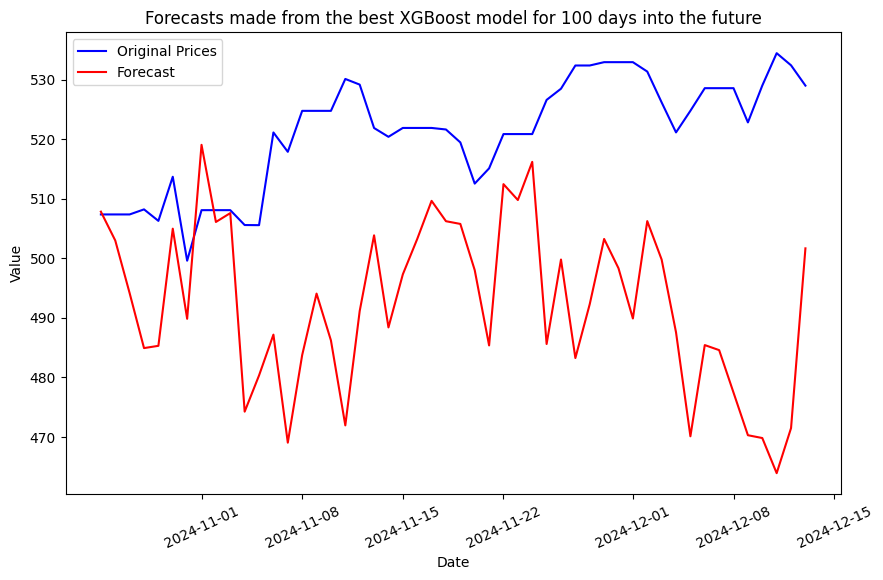

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_test, label = "Original Prices", color = "blue")
plt.plot(X_test.index, y_pred, label = "Forecast", color = "red")

# Add labels and title
plt.title("Forecasts made from the best XGBoost model for 100 days into the future")
plt.xlabel("Date")
plt.ylabel("Value")
plt.xticks(rotation = 25)
plt.legend()

# Show the plot
plt.show()

## Save the best XGB model

In [45]:
dump(best_model, "./models/best_XGBRegressor_v1.pkl")

['./models/best_XGBRegressor_v1.pkl']